<a href="https://colab.research.google.com/github/goerlitz/image-classification/blob/master/catsdogs/Cats_%26_Dogs_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats vs. Dogs: Transfer Learning with little data

This kernel is inspired by the Keras blog post [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) (by Francois Chollet, Sun 05 June 2016). **This blog post is a must read for everyone interested in transfer learning with ConvNets.**

Following, we will learn how to

1. reproduce the results of the blog post - using limited training data (2000 images) and a pretrained VGG16 model.
2. compare the performance of VGG16 with other pretrained Convolutional Nets (InceptionV3 and ResNet50).

# PART I

**Reproduce results from [Building powerful image classification models using very little data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)**

1. Training a small convnet from scratch (~80% accuracy)
2. Using the bottleneck features of a pre-trained VGG-16 network (~90% accuracy)
3. Fine-tuning the top layers of a a pre-trained VGG-16 network (~93% accuracy)

## Pre-requisites

### Dataset Preparation

The setup in the [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) uses only 2000 training examples (1000 per class) and 400 validation examples (200 per class) which are located in separate folders. Therefore, we create the same folder structure and copy 1000+400 cat and dog images each from the full dataset of 25,000 images.

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import optimizers

print('TensorFlow', tf.__version__)

TensorFlow 1.14.0


Using TensorFlow backend.


## Download Data

In [2]:
%%time
!if [[ ! -d data ]]; then mkdir data; fi && \
    if [[ ! -f dogscats.zip ]]; then wget http://files.fast.ai/data/dogscats.zip; fi && \
    unzip -qq -o dogscats.zip -d data/

CPU times: user 55.3 ms, sys: 13.7 ms, total: 69 ms
Wall time: 11.9 s


# Inspect Data

In [3]:
!du data/ -h

253M	data/dogscats/train/cats
295M	data/dogscats/train/dogs
548M	data/dogscats/train
4.0K	data/dogscats/models
298M	data/dogscats/test1
156K	data/dogscats/sample/train/cats
204K	data/dogscats/sample/train/dogs
364K	data/dogscats/sample/train
72K	data/dogscats/sample/valid/cats
104K	data/dogscats/sample/valid/dogs
216K	data/dogscats/sample/valid
584K	data/dogscats/sample
22M	data/dogscats/valid/cats
26M	data/dogscats/valid/dogs
48M	data/dogscats/valid
893M	data/dogscats
893M	data/


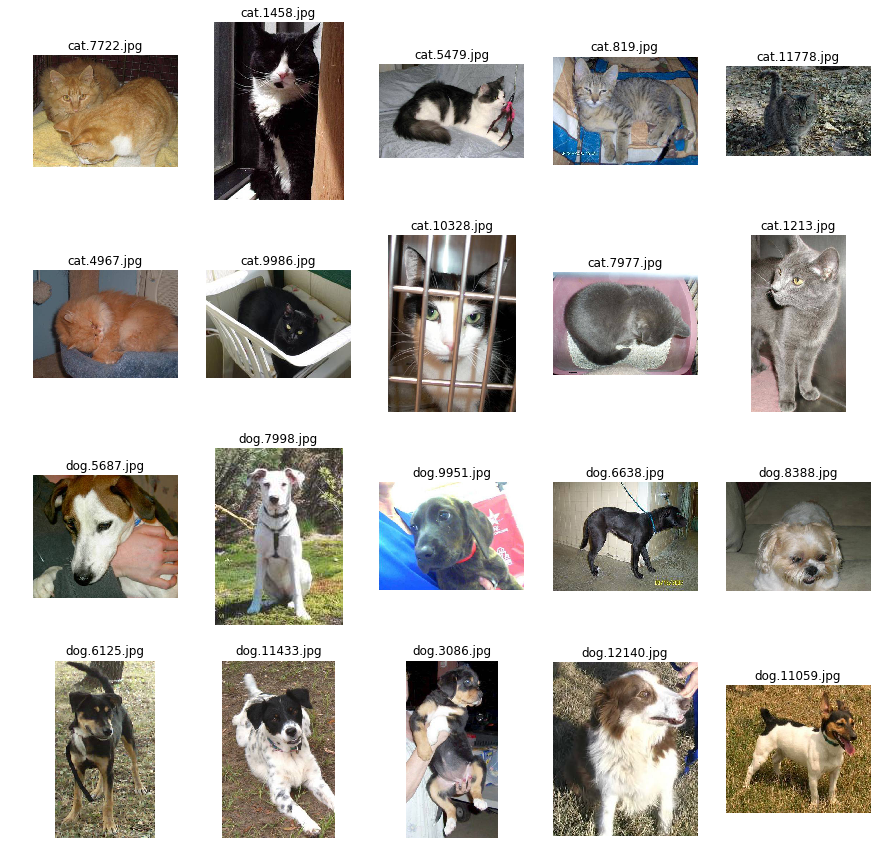

In [4]:
data_folder = Path('data/dogscats/')

train_folders = [data_folder/'train'/x for x in ['cats', 'dogs']]
pathlist = [[path/f for f in os.listdir(path)[:10]] for path in train_folders]

fig, axs = plt.subplots(4, 5, figsize=(15,15))

for ax, path in zip(axs.flatten(), [p for paths in pathlist for p in paths]):
    ax.imshow(plt.imread(path))
    ax.set_title(path.name)
    ax.axis('off')

### Data Augmentation

Data augmentation is a common approach to prevent overfitting by creating variations of the original training images. The  `DataImageGenerator` is used to apply different transformations on the images (e.g. rotating, zooming, flipping, shifting the images).

In [0]:
# define image transformations
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img_samples = 16
image_dir = '../preview/'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

img = load_img(data_folder/'train/cats/cat.8.jpg')
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

from itertools import islice
list(islice(datagen.flow(x, batch_size=1, save_to_dir=image_dir, save_prefix='cat', save_format='jpeg'), img_samples));

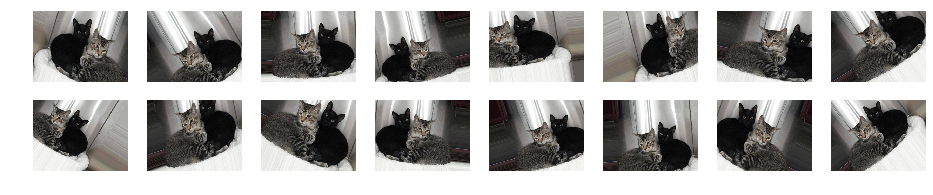

In [6]:
rows, cols = 2, img_samples // 2
fig, axs = plt.subplots(rows, cols, figsize=(16,3))

for ax, img in zip(axs.flatten(), os.listdir(image_dir)[:img_samples]):
    ax.imshow(load_img(image_dir+img))
    ax.axis('off')

## Training a Small ConvNet from Scratch

A classic setup of three convolution layers with a ReLU activation, followed by max-pooling layers. On top two fully-connected layers and a signle node with sigmoid activation for binary classification (cat or dog).

In [7]:
import numpy as np
import pandas as pd
import keras, tensorflow
import time

print('Keras', keras.__version__)
print('TensorFlow', tensorflow.__version__)

Keras 2.2.4
TensorFlow 1.14.0


In [8]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

input_tensor = Input(shape=(150,150,3))  # input_shape for Theano should be (3, 150,150)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150,150,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

W0821 23:57:03.431176 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 23:57:03.450478 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 23:57:03.456164 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 23:57:03.470911 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0821 23:57:03.515890 140442706134912 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 18496)             0         
__________

In [9]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0821 23:57:03.571273 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 23:57:03.593783 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0821 23:57:03.599776 140442706134912 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Provide Training and Validation Image Using ImageDataGenerator

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input

train_dir      = data_folder/'train'
validation_dir = data_folder/'valid'

train_samples      = 2000
validation_samples = 800

target_size    = (150,150)  # all images will be resized to 150x150
batch_size     = 16

# rescale and augment training data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True
        )

# rescale validation data
validation_datagen = ImageDataGenerator(
    rescale=1./255
    #preprocessing_function=preprocess_input
    )

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


Ready for training. ~16s per epoch on GPU, ~60s per epoch on CPU.

In [11]:
%%time
epochs = 30

start_time = time.time()
history_simple = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
 - 18s - loss: 0.7084 - acc: 0.5350 - val_loss: 0.6753 - val_acc: 0.5088
Epoch 2/30
 - 14s - loss: 0.6577 - acc: 0.6050 - val_loss: 0.6214 - val_acc: 0.6737
Epoch 3/30
 - 14s - loss: 0.6514 - acc: 0.6390 - val_loss: 0.7065 - val_acc: 0.5925
Epoch 4/30
 - 14s - loss: 0.6387 - acc: 0.6455 - val_loss: 0.6410 - val_acc: 0.6300
Epoch 5/30
 - 14s - loss: 0.6285 - acc: 0.6560 - val_loss: 0.6622 - val_acc: 0.5887
Epoch 6/30
 - 14s - loss: 0.6055 - acc: 0.6765 - val_loss: 0.7079 - val_acc: 0.6250
Epoch 7/30
 - 14s - loss: 0.5714 - acc: 0.7040 - val_loss: 0.5031 - val_acc: 0.7488
Epoch 8/30
 - 14s - loss: 0.5623 - acc: 0.7070 - val_loss: 0.5335 - val_acc: 0.7325
Epoch 9/30
 - 14s - loss: 0.5450 - acc: 0.7360 - val_loss: 0.5140 - val_acc: 0.7438
Epoch 10/30
 - 14s - loss: 0.5468 - acc: 0.7300 - val_loss: 0.5408 - val_acc: 0.7338
Epoch 11/30
 - 14s - loss: 0.5419 - acc: 0.7420 - val_loss: 0.4761 - val_acc: 0.7600
Epoch 12/30
 - 14s - loss: 0.5344 - acc: 0.7430 - val_loss: 0.5418 - val_a

### Investigating Model Accuracy

The results can vary due to the random initialization. But the (validation) accuracy should be more or less close to 80% (like in the original blog post). Looking at the graphs we ses that the training accuracy continuously improves while the validation accuracy does not change much after ~15 epochs - a clear sign for overfitting.

In [0]:
def plot_history(history, acc_line=None, title=None, acc_lim=[0.5,1.0]):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
    if title:
        fig.suptitle(title, fontsize=16)
    
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    if acc_line:
        ax1.axhline(y=acc_line, linewidth=2, linestyle='dashed', color='lightgrey')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    #ax1.set_yticks(np.arange(0., 1.1, .1))
    ax1.set_ylim(acc_lim)
    ax1.legend(['Train', 'Test'])
    ax1.grid(b=True, which='major', color='lightgrey', linestyle='dotted')
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim([0, 1.2])
    ax2.legend(['Train', 'Test'])
    ax2.grid(b=True, which='major', color='lightgrey', linestyle='dotted')

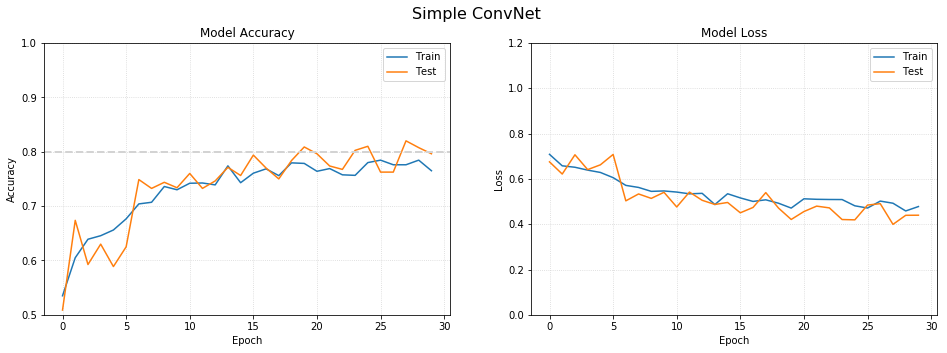

In [13]:
plot_history(history_simple, acc_line=0.8, title='Simple ConvNet')

## Using bottleneck features of a pre-trained VGG16 network

As in the blog post we will be using VGG16 with pre-trained weights based on ImageNet divided into two steps:

  * compute bottleneck features for all 2000 training images and 800 validation images of cats and dogs
  * create new binary classifier and train it with bottleneck features.

**Note: there is no data augmentation applied - so expect to see more overfitting.**

### Create VGG16 model with pre-trained weights

**Important**: Exclude the top layers (the dense classfication layers) because we are only interested in the output of the convolutional layers.

In [14]:
!curl -LRO https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   639    0   639    0     0   2298      0 --:--:-- --:--:-- --:--:--  2290
100 56.1M  100 56.1M    0     0  47.4M      0  0:00:01  0:00:01 --:--:--  109M


In [0]:
from keras.applications.vgg16 import VGG16

weights_vgg16 = 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model_vgg16 = VGG16(weights=weights_vgg16, include_top=False, input_shape=(150,150,3))

### Extract Bottleneck Features

See also the [code referenced in Keras blog post](https://gist.github.com/fchollet/f35fbc80e066a49d65f1688a7e99f069).

In [16]:
%%time
def get_bottleneck_features(model, image_dir, target_size, samples, batch_size=16):
    datagen = ImageDataGenerator(
        rescale=1./255
        #preprocessing_function=preprocess_input
        )
    generator = datagen.flow_from_directory(image_dir,
                                            target_size=target_size,
                                            batch_size=batch_size,
                                            class_mode=None,
                                            shuffle=False)
    return model.predict_generator(generator, samples // batch_size)

train_data_vgg16 = get_bottleneck_features(base_model_vgg16, train_dir, target_size, train_samples, batch_size)
print('created bottleneck features for training:', train_data_vgg16.shape)

validation_data_vgg16 = get_bottleneck_features(base_model_vgg16, validation_dir, target_size, validation_samples, batch_size)
print('created bottleneck features for validation:', validation_data_vgg16.shape)

train_labels = np.array([0] * (train_samples // 2) + [1] * (train_samples // 2))
validation_labels = np.array([0] * (validation_samples // 2) + [1] * (validation_samples // 2))

Found 23000 images belonging to 2 classes.
created bottleneck features for training: (2000, 4, 4, 512)
Found 2000 images belonging to 2 classes.
created bottleneck features for validation: (800, 4, 4, 512)
CPU times: user 14.3 s, sys: 4.25 s, total: 18.5 s
Wall time: 11.4 s


### Train a Classifier with Bottleneck Features

Classifier Setup: A dense layer with 256 neurons plus Dropout of 0.5 with a final layer of one neuron.

In [0]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout

def get_top_model(input_shape):
    input = Input(input_shape)
    x = Flatten()(input)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    prediction = Dense(1, activation='sigmoid')(x)
    return Model(inputs=input, outputs=prediction)

top_model_vgg16 = get_top_model(train_data_vgg16.shape[1:])

top_model_vgg16.compile(loss='binary_crossentropy',
                        optimizer='rmsprop',
                        #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
                        #optimizer=optimizers.RMSprop(lr=1e-5),
                        metrics=['accuracy'])

In [18]:
epochs = 30

start_time = time.time()
history_vgg16_top = top_model_vgg16.fit(train_data_vgg16, train_labels,
                                        verbose=2,
                                        epochs=epochs,
                                        batch_size=batch_size,
                                        validation_data=(validation_data_vgg16, validation_labels))
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Train on 2000 samples, validate on 800 samples
Epoch 1/30
 - 1s - loss: 1.1673 - acc: 0.4930 - val_loss: 0.6940 - val_acc: 0.4800
Epoch 2/30
 - 1s - loss: 0.7329 - acc: 0.5255 - val_loss: 0.7004 - val_acc: 0.5175
Epoch 3/30
 - 1s - loss: 0.7055 - acc: 0.5430 - val_loss: 0.6976 - val_acc: 0.5125
Epoch 4/30
 - 1s - loss: 0.6907 - acc: 0.5600 - val_loss: 0.7087 - val_acc: 0.4863
Epoch 5/30
 - 1s - loss: 0.6722 - acc: 0.5960 - val_loss: 0.7187 - val_acc: 0.5125
Epoch 6/30
 - 1s - loss: 0.6489 - acc: 0.6155 - val_loss: 0.7164 - val_acc: 0.5175
Epoch 7/30
 - 1s - loss: 0.6344 - acc: 0.6470 - val_loss: 0.7796 - val_acc: 0.5088
Epoch 8/30
 - 1s - loss: 0.5989 - acc: 0.6755 - val_loss: 0.7797 - val_acc: 0.5325
Epoch 9/30
 - 1s - loss: 0.5679 - acc: 0.6955 - val_loss: 0.7685 - val_acc: 0.5175
Epoch 10/30
 - 1s - loss: 0.5455 - acc: 0.7180 - val_loss: 0.8374 - val_acc: 0.5150
Epoch 11/30
 - 1s - loss: 0.5295 - acc: 0.7265 - val_loss: 0.8928 - val_acc: 0.5038
Epoch 12/30
 - 1s - loss: 0.5090 - acc

In [0]:
model_weigths_file = 'bottleneck_fc_model_vgg16.h5'
top_model_vgg16.save_weights(model_weigths_file)

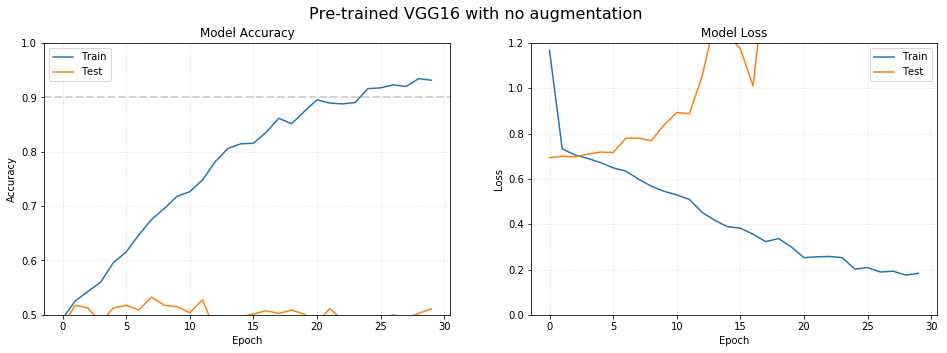

In [20]:
plot_history(history_vgg16_top, acc_line=0.9, title='Pre-trained VGG16 with no augmentation', acc_lim=[0.5,1.0])

## Fine-tuning the top layers of a pre-trained network

**CAUTION:** The [original code](https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975) in the blog article using `base_model.add()` to join the pre-trained VGG16 model with the pre-trained classifier does not work (anymore). Instead, a new `Sequential` model has to be created. (see also https://github.com/keras-team/keras/issues/7338#issuecomment-315973050).

In [0]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Dense, Dropout

In [22]:
# load pre-trained VGG16 network (without classfication layers)
base_model_vgg16 = VGG16(weights=weights_vgg16, include_top=False, input_shape=(150,150,3))
print('Model loaded.')

# set all but the last the last conv block to non-trainable (weights will not be updated)
for layer in base_model_vgg16.layers[:15]:
    layer.trainable = False

# create a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=base_model_vgg16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))
top_model.load_weights(model_weigths_file)

# add the model on top of the convolutional base
model = Model(inputs = base_model_vgg16.input, outputs = top_model(base_model_vgg16.output))

Model loaded.


In [0]:
from keras import optimizers

# compile model with a very slow learning rate
model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              #optimizer=optimizers.RMSprop(lr=1e-5),
              optimizer=optimizers.Adam(lr=1e-5),
              metrics=['accuracy'])

In [24]:
epochs = 30

start_time = time.time()
history_tuned = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
 - 17s - loss: 0.8221 - acc: 0.5785 - val_loss: 0.5797 - val_acc: 0.6913
Epoch 2/30
 - 16s - loss: 0.5713 - acc: 0.7150 - val_loss: 0.4092 - val_acc: 0.8175
Epoch 3/30
 - 16s - loss: 0.4679 - acc: 0.7915 - val_loss: 0.3941 - val_acc: 0.8363
Epoch 4/30
 - 16s - loss: 0.4233 - acc: 0.8160 - val_loss: 0.3056 - val_acc: 0.8750
Epoch 5/30
 - 16s - loss: 0.3550 - acc: 0.8535 - val_loss: 0.2594 - val_acc: 0.8850
Epoch 6/30
 - 16s - loss: 0.3240 - acc: 0.8580 - val_loss: 0.2200 - val_acc: 0.8988
Epoch 7/30
 - 16s - loss: 0.2948 - acc: 0.8690 - val_loss: 0.2568 - val_acc: 0.8938
Epoch 8/30
 - 16s - loss: 0.2700 - acc: 0.8915 - val_loss: 0.2459 - val_acc: 0.8975
Epoch 9/30
 - 16s - loss: 0.2552 - acc: 0.8990 - val_loss: 0.2111 - val_acc: 0.9075
Epoch 10/30
 - 16s - loss: 0.2487 - acc: 0.9000 - val_loss: 0.2310 - val_acc: 0.9062
Epoch 11/30
 - 16s - loss: 0.2662 - acc: 0.8945 - val_loss: 0.2017 - val_acc: 0.9187
Epoch 12/30
 - 16s - loss: 0.2271 - acc: 0.9065 - val_loss: 0.1904 - val_a

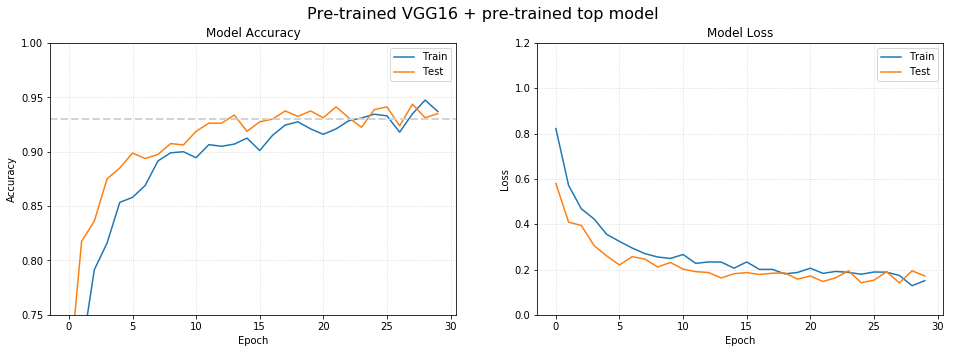

In [25]:
plot_history(history_tuned, acc_line=0.93, title='Pre-trained VGG16 + pre-trained top model', acc_lim=[0.75,1.0])

# PART II

**Compare different pretrained convolutional networks.**

1. VGG-16 (~90% accuracy)
2. Inception v3  (~95% accuracy)
3. ResNet-50  (~98% accuracy)

### Create VGG16 model with pre-trained weights

In [26]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout

# build the VGG16 network
base_model = VGG16(weights=weights_vgg16, include_top=False, input_shape=(150,150,3))

# freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_vgg16base = Model(inputs=base_model.input, outputs=predictions)

print(model_vgg16base.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [0]:
model_vgg16base.compile(loss='binary_crossentropy',
                        optimizer='rmsprop',
                        metrics=['accuracy'])

In [28]:
epochs = 30

start_time = time.time()
history_vgg16base = model_vgg16base.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
125/125 [==============================] - 18s 144ms/step - loss: 0.7493 - acc: 0.7320 - val_loss: 0.3329 - val_acc: 0.8462
Epoch 2/30
125/125 [==============================] - 16s 129ms/step - loss: 0.4295 - acc: 0.8160 - val_loss: 0.2629 - val_acc: 0.8950
Epoch 3/30
125/125 [==============================] - 16s 128ms/step - loss: 0.3878 - acc: 0.8465 - val_loss: 0.2684 - val_acc: 0.8912
Epoch 4/30
125/125 [==============================] - 16s 127ms/step - loss: 0.3979 - acc: 0.8270 - val_loss: 0.2679 - val_acc: 0.8762
Epoch 5/30
125/125 [==============================] - 16s 126ms/step - loss: 0.3825 - acc: 0.8330 - val_loss: 0.2615 - val_acc: 0.8838
Epoch 6/30
125/125 [==============================] - 16s 127ms/step - loss: 0.3781 - acc: 0.8435 - val_loss: 0.3077 - val_acc: 0.8700
Epoch 7/30
125/125 [==============================] - 16s 125ms/step - loss: 0.3453 - acc: 0.8565 - val_loss: 0.2275 - val_acc: 0.9025
Epoch 8/30
125/125 [==============================] - 1

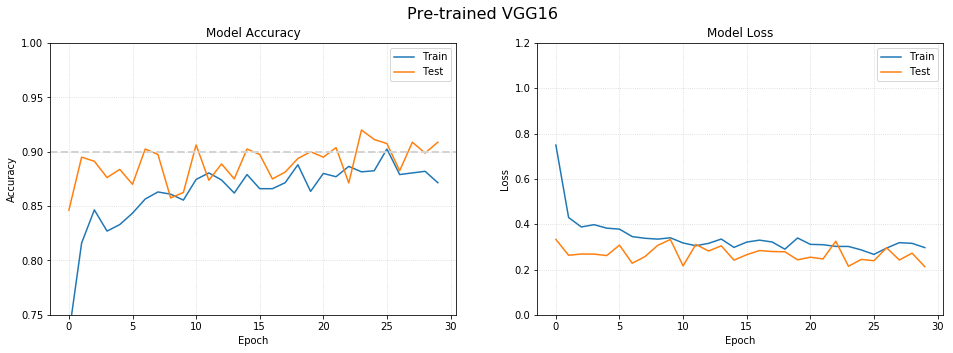

In [29]:
plot_history(history_vgg16base, acc_line=0.9, title='Pre-trained VGG16', acc_lim=[0.75, 1.0])

### Use Pre-trained InceptionV3 Model

In [30]:
!curl -LRO https://github.com/fchollet/deep-learning-models/releases/download/v0.5/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   646    0   646    0     0   3491      0 --:--:-- --:--:-- --:--:--  3491
100 83.8M  100 83.8M    0     0  59.8M      0  0:00:01  0:00:01 --:--:-- 87.2M


In [31]:
from keras.applications.inception_v3 import InceptionV3

weights_incv3 = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# load pre-trained weights and add global average pooling layer
base_model_incv3 = InceptionV3(weights=weights_incv3, input_shape=(150,150,3), include_top=False, pooling='avg')

# freeze convolutional layers
for layer in base_model_incv3.layers:
    layer.trainable = False

# define classification layers
#x = Dense(1024, activation='relu')(base_model_incv3.output)
#predictions = Dense(1, activation='sigmoid')(x)
x = Dense(256, activation='relu')(base_model_incv3.output)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

model_incv3 = Model(inputs=base_model_incv3.input, outputs=predictions)
#print(model_incv3.summary())

W0822 00:20:42.599404 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0822 00:20:43.431625 140442706134912 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



### Prepare Model Training Setup

In [0]:
model_incv3.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.0001),
                    metrics=['accuracy'])

### Provide Training and Validation Images using ImageDataGenerator

**Caution**: InceptionV3 requires a different image preprocessing than VGG.

In [33]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

def prep(image):
    # copy image to prevent overwriting
    return preprocess_input(image.copy())

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=prep)

test_datagen = ImageDataGenerator(preprocessing_function=prep)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [34]:
epochs = 30

start_time = time.time()
history_incv3 = model_incv3.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
125/125 [==============================] - 20s 162ms/step - loss: 0.5878 - acc: 0.6785 - val_loss: 0.2281 - val_acc: 0.8975
Epoch 2/30
125/125 [==============================] - 16s 131ms/step - loss: 0.4980 - acc: 0.7420 - val_loss: 0.3063 - val_acc: 0.9137
Epoch 3/30
125/125 [==============================] - 16s 130ms/step - loss: 0.4779 - acc: 0.7605 - val_loss: 0.2028 - val_acc: 0.9300
Epoch 4/30
125/125 [==============================] - 16s 130ms/step - loss: 0.4667 - acc: 0.7785 - val_loss: 0.1882 - val_acc: 0.9387
Epoch 5/30
125/125 [==============================] - 16s 129ms/step - loss: 0.4156 - acc: 0.8040 - val_loss: 0.1918 - val_acc: 0.9387
Epoch 6/30
125/125 [==============================] - 16s 129ms/step - loss: 0.4221 - acc: 0.8045 - val_loss: 0.2308 - val_acc: 0.9313
Epoch 7/30
125/125 [==============================] - 16s 130ms/step - loss: 0.4359 - acc: 0.7965 - val_loss: 0.2168 - val_acc: 0.9475
Epoch 8/30
125/125 [==============================] - 1

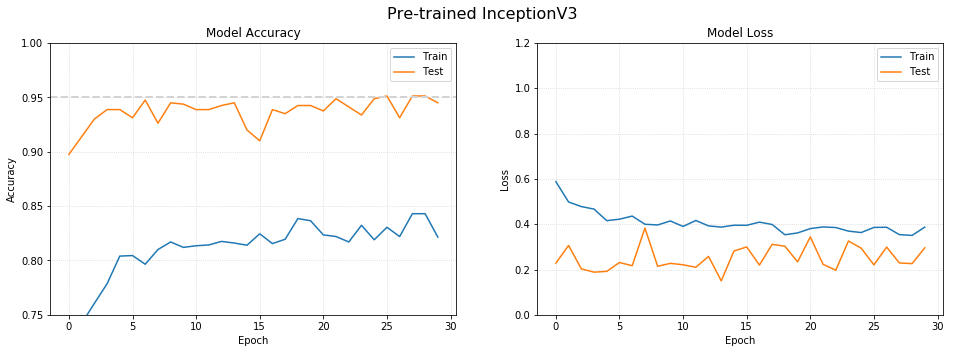

In [35]:
plot_history(history_incv3, acc_line=0.95, title="Pre-trained InceptionV3", acc_lim=[0.75,1.0])

## ResNet50

In [36]:
!curl -LRO https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   642    0   642    0     0   3275      0 --:--:-- --:--:-- --:--:--  3275
100 90.2M  100 90.2M    0     0  44.9M      0  0:00:02  0:00:02 --:--:-- 71.4M


In [0]:
from keras.applications.resnet50 import ResNet50, preprocess_input

weights_resnet50 = 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model = ResNet50(weights = weights_resnet50, include_top = False, pooling = 'avg')

In [38]:
model = Sequential()
model.add(base_model)

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.layers[0].trainable = False
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_11 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 24,112,513
Trainable params: 524,801
Non-trainable params: 23,587,712
_________________________________________________________________
None


In [0]:
model.compile(loss='binary_crossentropy',
                    optimizer=optimizers.RMSprop(lr=0.0001),
                    metrics=['accuracy'])

In [40]:
def prep(image):
    # copy image to prevent overwriting
    return preprocess_input(image.copy())

train_datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        preprocessing_function=prep)

test_datagen = ImageDataGenerator(preprocessing_function=prep)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [41]:
epochs = 30

start_time = time.time()
history_resnet50 = model.fit_generator(
    train_generator,
    steps_per_epoch=train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_samples // batch_size)
print("--- took %d:%.2d minutes ---" % divmod(time.time() - start_time, 60))

Epoch 1/30
125/125 [==============================] - 22s 179ms/step - loss: 0.3824 - acc: 0.8210 - val_loss: 0.1253 - val_acc: 0.9487
Epoch 2/30
125/125 [==============================] - 17s 137ms/step - loss: 0.2433 - acc: 0.9000 - val_loss: 0.0939 - val_acc: 0.9650
Epoch 3/30
125/125 [==============================] - 17s 136ms/step - loss: 0.2008 - acc: 0.9245 - val_loss: 0.0924 - val_acc: 0.9675
Epoch 4/30
125/125 [==============================] - 17s 136ms/step - loss: 0.1945 - acc: 0.9210 - val_loss: 0.1041 - val_acc: 0.9700
Epoch 5/30
125/125 [==============================] - 17s 137ms/step - loss: 0.1979 - acc: 0.9210 - val_loss: 0.1029 - val_acc: 0.9613
Epoch 6/30
125/125 [==============================] - 17s 137ms/step - loss: 0.1879 - acc: 0.9255 - val_loss: 0.0872 - val_acc: 0.9663
Epoch 7/30
125/125 [==============================] - 17s 137ms/step - loss: 0.1869 - acc: 0.9255 - val_loss: 0.1136 - val_acc: 0.9675
Epoch 8/30
125/125 [==============================] - 1

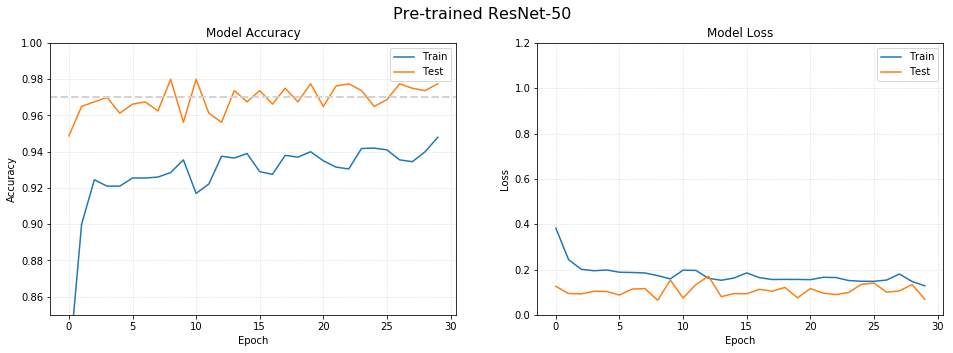

In [42]:
plot_history(history_resnet50, acc_line=0.97, title="Pre-trained ResNet-50", acc_lim=[0.85,1.0])